In [1]:
import pandas as pd
import glob
import numpy as np

from urllib.request import urlretrieve
import os

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import spacy

import ast
import matplotlib.pyplot as plt

from collections import Counter
import re

In [1]:
with open('./s2orc_full_text_nlp_ml.txt') as f:
    lines = f.read().splitlines()

In [2]:
# from urllib.request import urlretrieve
# import gzip, shutil

# for fname in lines:
#     if not fname.startswith('https:/'):
#         fname = 'https://ai2-s2-research-public.s3-us-west-2.amazonaws.com/lucas/s2orc' + fname.split('s2orc')[1]
        
#     path, _ = urlretrieve(fname, './raw-data/' + fname.split('/')[-1])

#     with gzip.open(path, 'r') as f_in, open('.'.join(path.split('.')[:-1]).replace('raw-data', 'processed-data'), 'wb') as f_out:
#         shutil.copyfileobj(f_in, f_out)

In [3]:
path = "raw-data"
does_exist = os.path.exists(path)
if not does_exist:
    os.makedirs(path)

    for fname in lines:
        if not fname.startswith('https:/'):
            fname = 'https://ai2-s2-research-public.s3-us-west-2.amazonaws.com/lucas/s2orc' + fname.split('s2orc')[1]

        path, _ = urlretrieve(fname, './raw-data/' + fname.split('/')[-1])

        pd.read_parquet(path)
        print(path)

In [5]:
def process_text(text):
    wnpos = lambda e: ('a' if e[0].lower() == 'j' else e[0].lower()) if e[0].lower() in ['n', 'r', 'v'] else 'n'
    wnl = WordNetLemmatizer()

    tokens = word_tokenize(text)
    tokens_pos = pos_tag(tokens)
    lemmas = []
    for t, pos in tokens_pos:
        new_pos = wnpos(pos)
        lemmas.append(wnl.lemmatize(t, pos=new_pos))
    return lemmas

In [6]:
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

search_terms = ['democra']
exclude_term = 'democrats'

matches = list()
num_nonreadable = 0

for filepath in glob.iglob('raw-data/*'):
    df = pd.read_parquet(filepath)
    
    for index, row in df.iterrows():
        for target in [row['metadata']['title'], row['metadata']['abstract'], row['content']['grobid']['contents']]:
            if target:
                target_sents = nltk.tokenize.sent_tokenize(target)
            else:
                num_nonreadable += 1
                continue
            
            for s in search_terms:
                matches.extend([(row['id'], m) for m in target_sents if s in m.lower() and exclude_term not in m.lower()])

In [7]:
num_nonreadable

2082

In [8]:
matches_df = pd.DataFrame(matches, columns=['Corpus ID', 'Excerpt'])

In [9]:
matches_df.sample(frac=1).to_csv('excerpts.csv')

In [10]:
matches_df

,Corpus ID,Excerpt
0,258378195,Table 2 :\n2Some statisics for our new data se...
1,258378195,Populism versus democracy.
2,258378195,Populism ver- sus democracy.
3,258378195,"Werner Wirth, Martin Wettstein, Dominique Wirz..."
4,208909894,Pratham Books 4 is a non-profit organization w...
...,...,...
3406,233365240,On the democratic role of news recommenders.
3407,233365240,On the democratic role of news recommenders.
3408,226283642,"In rural Virginia, Sen. Warner ran 8 -10 point..."
3409,226283642,They go into a voting booth having no idea wha...


## Over Time

In [3]:
filtered_papers = set(pd.read_csv('excerpts.csv')['Corpus ID'])

In [4]:
all_years = []
filtered_rows = []

for filepath in glob.iglob('raw-data/*'):
    df = pd.read_parquet(filepath)
    
    for index, row in df.iterrows():
        if row['id'] in filtered_papers:
            filtered_rows.append(row)
            
        if row['metadata']['publication_date'] and row['metadata']['publication_date']['year']:
            all_years.append(row['metadata']['publication_date']['year'])

In [5]:
df = pd.DataFrame(filtered_rows)

In [6]:
filtered_years = []

for index, row in df.iterrows():
    if row['metadata']['publication_date'] and row['metadata']['publication_date']['year']:
        filtered_years.append(row['metadata']['publication_date']['year'])

In [7]:
import numpy as np
import matplotlib.pyplot as plt

filtered_uniq, filtered_counts = np.unique(filtered_years, return_counts=True)

In [8]:
denom = (filtered_uniq.reshape(-1, 1) == np.array(all_years).reshape(1, -1)).sum(axis=1)

In [9]:
filtered_uniq

array([1969., 1974., 1975., 1976., 1977., 1978., 1979., 1980., 1982.,
       1983., 1984., 1985., 1986., 1987., 1988., 1989., 1990., 1991.,
       1992., 1993., 1994., 1995., 1996., 1997., 1998., 1999., 2000.,
       2001., 2002., 2003., 2004., 2005., 2006., 2007., 2008., 2009.,
       2010., 2011., 2012., 2013., 2014., 2015., 2016., 2017., 2018.,
       2019., 2020., 2021., 2022., 2023.])

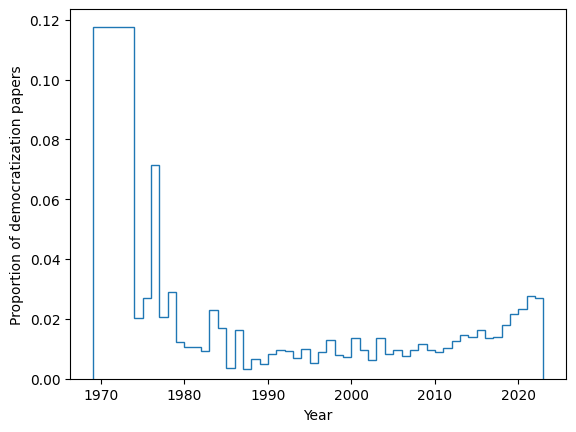

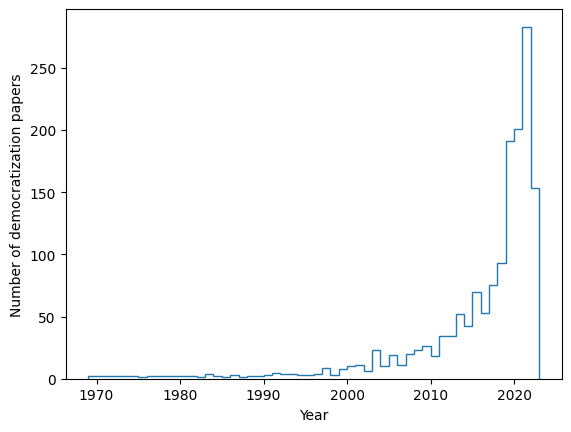

In [10]:
plt.stairs((filtered_counts / denom)[filtered_uniq > 1970], filtered_uniq[filtered_uniq >= 1969])
plt.xlabel("Year")
plt.ylabel("Proportion of democratization papers")
plt.show()

plt.stairs(filtered_counts[filtered_uniq > 1970], filtered_uniq[filtered_uniq >= 1969])
plt.xlabel("Year")
plt.ylabel("Number of democratization papers")
plt.show()

## Affiliations

In [11]:
# from s2aff import S2AFF
# from s2aff.ror import RORIndex
# from s2aff.model import NERPredictor, PairwiseRORLightGBMReranker

In [12]:
# # an example affiliation
# raw_affiliation = "Microsoft Research\nBangaloreIndia"

# # instantiate the ner model and the ror index. loading first time will take ~10-30s
# ner_predictor = NERPredictor(use_cuda=False)  # defaults to models in the data directory
# ror_index = RORIndex()  # ditto

In [13]:
# candidates, scores = ror_index.get_candidates_from_raw_affiliation("Argentina", ner_predictor)
# ror_index.ror_dict[candidates[0]]

In [14]:
exclude_terms = set([
    'germany',
    'department of linguistics',
    'uk',
    'school of computer science',
    'china',
    'usa',
    'computer science',
    'india',
    'italy',
    'berkeley',
    'united kingdom',
    'computer science department',
    'department of computer science and engineering',
    'department of computer science',
    'beijingchina',
])

In [15]:
all_affils = []

for index, row in df.iterrows():
    if row['content']['grobid']['annotations']['author_affiliation']:
        affiliation_pos = ast.literal_eval(row['content']['grobid']['annotations']['author_affiliation'])
        
        paper_affils = []
        for pos in affiliation_pos:
            start, end = pos['start'], pos['end']
            if type(start) != int:
                start = int(start)
            if type(end) != int:
                end = int(end)

            raw_affils = row['content']['grobid']['contents'][start:end].strip().lower().split('\n')
            paper_affils.extend(raw_affils)
            
        all_affils.extend(list(set([affil for affil in paper_affils if affil not in exclude_terms])))

In [16]:
# uniq_affils, counts_affils = np.unique(all_affils, return_counts=True)
# uniq_affils = uniq_affils[np.argsort(-counts_affils)]
# counts_affils = counts_affils[np.argsort(-counts_affils)]

In [17]:
# affils_map = {}

# for raw_affil in uniq_affils[:200]:
#     candidates, scores = ror_index.get_candidates_from_raw_affiliation(raw_affil, ner_predictor)
#     cand_info = ror_index.ror_dict[candidates[0]]
#     if "Education" in cand_info["types"] or "Company" in cand_info["types"] or "Nonprofit" in cand_info["types"]:
#         affils_map[raw_affil] = cand_info["name"]

In [18]:
# relabeled_affils = [affils_map[affil] for affil in all_affils if affil in affils_map]
# uniq_affils, counts_affils = np.unique(relabeled_affils, return_counts=True)

uniq_affils, counts_affils = np.unique(all_affils, return_counts=True)

k = 20
topk_affils = np.argsort(-counts_affils)[:k]
list(zip(uniq_affils[topk_affils], counts_affils[topk_affils]))

[('stanford university', 37),
 ('carnegie mellon university', 36),
 ('columbia university', 33),
 ('university of california', 31),
 ('cnrs', 26),
 ('university of edinburgh', 26),
 ('university of cambridge', 25),
 ('university of stuttgart', 22),
 ('university of copenhagen', 19),
 ('university of washington', 19),
 ('university of maryland', 17),
 ('university of michigan', 17),
 ('university of pennsylvania', 16),
 ('microsoft research', 16),
 ('university of amsterdam', 15),
 ('ibm research', 15),
 ('purdue university', 14),
 ('university of toronto', 13),
 ('johns hopkins university', 13),
 ('charles university', 13)]

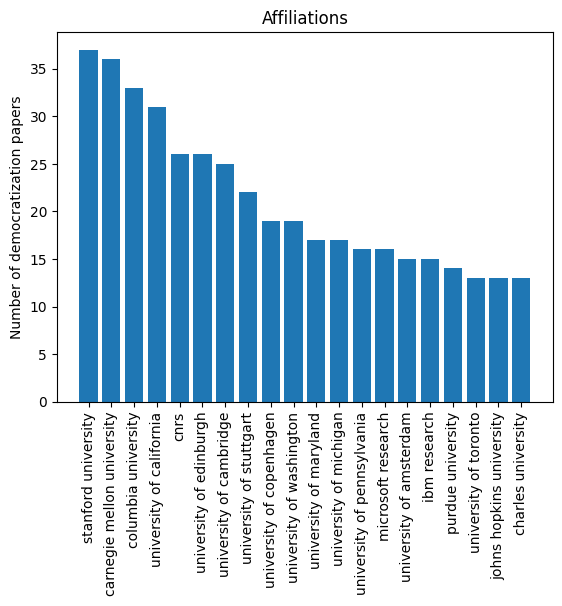

In [19]:
plt.bar(uniq_affils[topk_affils], counts_affils[topk_affils])
for tick in plt.gca().get_xticklabels():
    tick.set_rotation(90)
plt.ylabel('Number of democratization papers')
plt.title('Affiliations')
plt.show()

## Authors

In [20]:
all_authors = []

for index, row in df.iterrows():
    if row['metadata']['authors']:
        authors = ast.literal_eval(row['metadata']['authors'])
        
        for author in authors:
            all_authors.append(' '.join([author['first'].strip().lower()] + [t.strip().lower() for t in author['middle']] + [author['last'].strip().lower()]))

In [21]:
uniq_authors, counts_authors = np.unique(all_authors, return_counts=True)

In [22]:
k = 20
topk_authors = np.argsort(-counts_authors)[:k]
list(zip(uniq_authors[topk_authors], counts_authors[topk_authors]))

[('dan goldwasser', 17),
 ('preslav nakov', 16),
 ('noah a. smith', 13),
 ('ekaterina shutova', 12),
 ('gabriella lapesa', 10),
 ('heng ji', 8),
 ('sebastian padó', 8),
 ('kathleen mckeown', 8),
 ('noam slonim', 8),
 ('kyo kageura', 7),
 ('mark dredze', 7),
 ('douwe kiela', 7),
 ('yulia tsvetkov', 7),
 ('josef ruppenhofer', 7),
 ('percy liang', 7),
 ('henning wachsmuth', 7),
 ('lu wang', 6),
 ('trevor cohn', 6),
 ('iryna gurevych', 6),
 ('yulan he', 6)]

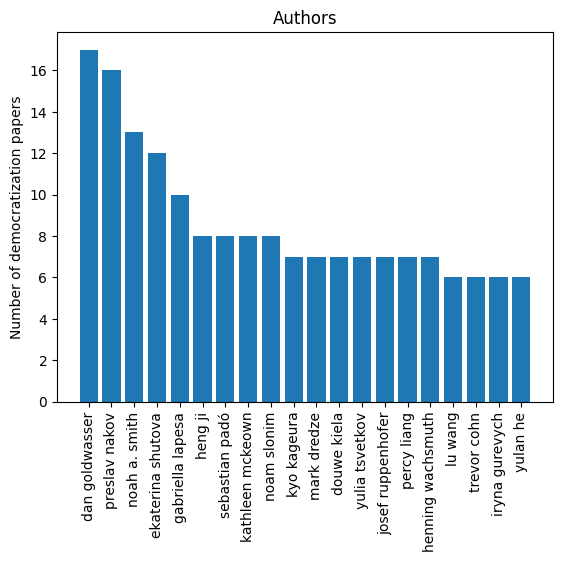

In [23]:
plt.bar(uniq_authors[topk_authors], counts_authors[topk_authors])
for tick in plt.gca().get_xticklabels():
    tick.set_rotation(90)
plt.ylabel('Number of democratization papers')
plt.title('Authors')
plt.show()

## Paper structure

In [24]:
excerpts_df = pd.read_csv('excerpts.csv')
excerpts_map = {}

for index, row in excerpts_df.iterrows():
    if row['Corpus ID'] not in excerpts_map:
        excerpts_map[row['Corpus ID']] = []
    excerpts_map[row['Corpus ID']].append(row['Excerpt'])

In [25]:
all_sections = []

for index, row in df.iterrows():
    for excerpt in excerpts_map[row['id']]:
        
        excerpt_idx = row['metadata']['title'].find(excerpt)
        if excerpt_idx != -1:
            all_sections.append("Title")
            continue

        if row['metadata']['abstract']:
            excerpt_idx = row['metadata']['abstract'].find(excerpt)
            if excerpt_idx != -1:
                all_sections.append("Abstract")
                continue
        
        excerpt_idx = row['content']['grobid']['contents'].find(excerpt)

        if row['content']['grobid']['annotations']['figure']:
            figures = ast.literal_eval(row['content']['grobid']['annotations']['figure'])
            figure_flag = False
            for figure in figures:
                start, end = figure['start'], figure['end']
                if type(start) != int:
                    start = int(start)
                if type(end) != int:
                    end = int(end)
                    
                if start <= excerpt_idx and end >= excerpt_idx + len(excerpt):
                    all_sections.append("Figure")
                    figure_flag = True
                    break
        if figure_flag:
            continue
        
        if row['content']['grobid']['annotations']['table']:
            tables = ast.literal_eval(row['content']['grobid']['annotations']['table'])
            table_flag = False
            for table in tables:
                start, end = table['start'], table['end']
                if type(start) != int:
                    start = int(start)
                if type(end) != int:
                    end = int(end)

                if start <= excerpt_idx and end >= excerpt_idx + len(excerpt):
                    all_sections.append("Table")
                    table_flag = True
                    break
        if table_flag:
            continue

        if row['content']['grobid']['annotations']['section_header']:
            section_headers = ast.literal_eval(row['content']['grobid']['annotations']['section_header'])

            prev_header = "Abstract"
            for header in section_headers:
                start, end = header['start'], header['end']
                if type(start) != int:
                    start = int(start)
                if type(end) != int:
                    end = int(end)

                curr_header = row['content']['grobid']['contents'][start:end]
                # if "::" in curr_header or "Table" in curr_header or "Figure" in curr_header:
                #     continue

                if excerpt_idx < start:
                    all_sections.append(prev_header)
                    break

                prev_header = curr_header

In [26]:
uniq_sections, counts_sections = np.unique(all_sections, return_counts=True)

In [27]:
topk_sections = np.argsort(-counts_sections)[:k]
list(zip(uniq_sections[topk_sections], counts_sections[topk_sections]))

[('Figure', 368),
 ('Introduction', 358),
 ('Abstract', 215),
 ('Conclusion', 49),
 ('Related Work', 24),
 ('Evaluation', 19),
 ('Conclusions', 17),
 ('Discussion', 15),
 ('Broader Impact', 14),
 ('Ethics Statement', 13),
 ('Results', 13),
 ('Title', 11),
 ('Data', 11),
 ('Error Analysis', 11),
 ('Table 3 :', 10),
 ('Table 4 :', 10),
 ('Table 1 :', 10),
 ('Related Work and Discussions', 9),
 ('C Examples of System Outputs', 9),
 ('Experiments', 9)]

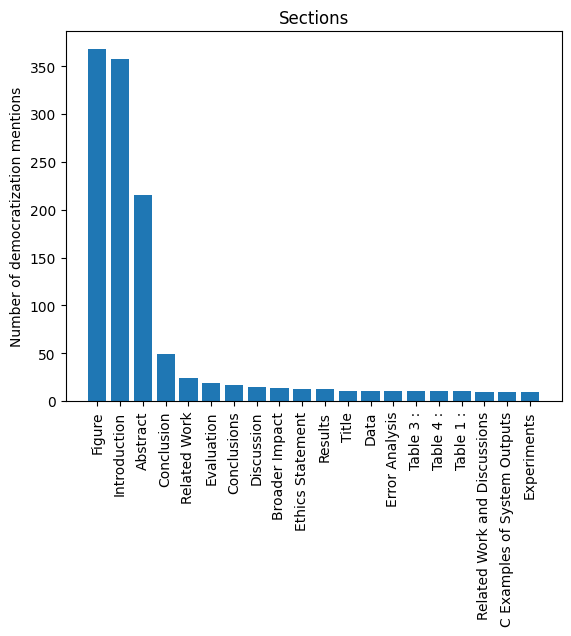

In [28]:
plt.bar(uniq_sections[topk_sections], counts_sections[topk_sections])
for tick in plt.gca().get_xticklabels():
    tick.set_rotation(90)
plt.ylabel('Number of democratization mentions')
plt.title('Sections')
plt.show()

In [29]:
all_freqs = [len(v) for k, v in excerpts_map.items()]

uniq_freqs, counts_freqs = np.unique(all_freqs, return_counts=True)
topk_freqs = np.argsort(-counts_freqs)[:k]
list(zip(uniq_freqs[topk_freqs], counts_freqs[topk_freqs]))

[(1, 865),
 (2, 369),
 (3, 118),
 (4, 75),
 (5, 36),
 (6, 19),
 (7, 13),
 (9, 7),
 (11, 6),
 (8, 5),
 (10, 4),
 (19, 3),
 (14, 3),
 (13, 2),
 (12, 2),
 (16, 1),
 (25, 1),
 (27, 1),
 (30, 1),
 (35, 1)]

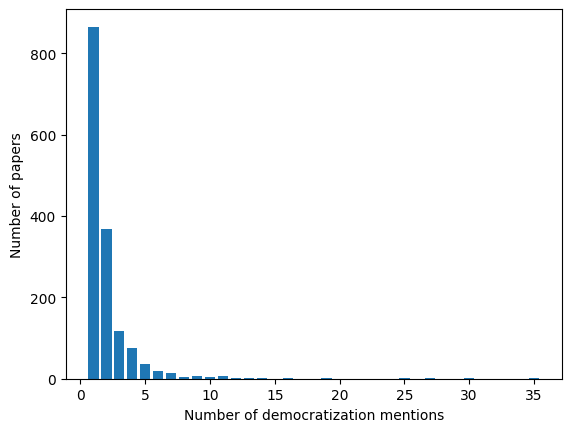

In [30]:
plt.bar(uniq_freqs[topk_freqs], counts_freqs[topk_freqs])
plt.ylabel('Number of papers')
plt.xlabel('Number of democratization mentions')
plt.show()

## Acknowledgments

In [31]:
nlp = spacy.load("en_core_web_lg")
print(nlp.get_pipe("ner").labels)

('CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART')


In [32]:
def add_children(tokens):
    for i, t in enumerate(tokens):
        tokens[i]['children'] = set()
    for i, t in enumerate(tokens):
        if t['dep'] != 'ROOT':
            head = t['head']
            tokens[head]['children'].add(t['id'])

def flood_children(tokens, i):
    seen = set()
    s = [i]
    while s != []:
        id = s.pop()
        seen.add(id)
        for ch in tokens[id]['children']:
            s.append(ch)
    return seen

def all_children(tok):
    seen = set()
    s = [tok]
    while s != []:
        t = s.pop()
        seen.add(t)
        for ch in t.children:
            s.append(ch)
    return sorted([t.i for t in seen])

def make_ignore_set(parse):
    ignore = set()

    # sentences about corresponding author
    for s in parse.sents:
        if 'corresponding author' in s.text or 'contact author' in s.text:
            for id in range(s.start, s.end):
                ignore.add(id)
    
    tokens = parse.to_json()['tokens']
    add_children(tokens)
    
    # passive subject of "is supported by"
    support_verbs = set(['support', 'fund'])
    for t in tokens:
        if t['lemma'] in support_verbs:
            for cid in t['children']:
                child = tokens[cid]
                if child['dep'] == 'nsubjpass':
                    for id in flood_children(tokens, child['id']):
                        ignore.add(id)
    
    return ignore

In [33]:
all_acks = []
num_paper_with_acks = 0

for index, row in df.iterrows():
    if row['content']['grobid']['annotations']['section_header']:
        section_headers = ast.literal_eval(row['content']['grobid']['annotations']['section_header'])

        prev_end = None
        for header in section_headers:
            start, end = header['start'], header['end']
            if type(start) != int:
                start = int(start)
            if type(end) != int:
                end = int(end)

            if prev_end is not None:
                ack = row['content']['grobid']['contents'][prev_end:start].replace("-\n", "").replace("\n", "").strip()
                all_acks.append(ack)
                break

            curr_header = row['content']['grobid']['contents'][start:end]
            if "Acknowledg" in curr_header or "Funding" in curr_header or "Disclosure" in curr_header:
                num_paper_with_acks += 1
                prev_end = end

In [34]:
parses = [nlp(ack) for ack in all_acks]
print([[(e, e.label_) for e in p.ents] for p in parses])

[[(NVIDIA, 'ORG'), (Huan Ling, 'PERSON'), (Seung Wook Kim, 'PERSON'), (University of Toronto, 'ORG'), (the Vector Institute, 'ORG')], [], [(Natalie Schluter, 'PERSON'), (Roam Analytics, 'ORG'), (the Dublin City University Faculty of Engineering & Computing, 'ORG'), (the Daniel O'Hare Research Schol, 'ORG'), (the ADAPT Centre, 'ORG'), (Digital Content Technology, 'ORG'), (the SFI Research Centres Programme, 'ORG'), (Grant 13/RC/2106, 'ORG'), (the European Regional Development Fund, 'ORG'), (ZH-EN NMT, 'ORG'), (three, 'CARDINAL'), (RNN, 'ORG'), (RNN, 'ORG'), (RNN, 'ORG'), (Nadejde, 'PERSON'), (2017, 'DATE'), (Li et ala, 'PERSON'), (EU, 'ORG'), (Switzerland, 'GPE'), (In the course|EVENT of my work|ACT, 'WORK_OF_ART')], [(Pengfei Liu, 'PERSON')], [(Defense Advanced Research Projects Agency Information Innovation Office, 'ORG'), (DARPA, 'ORG'), (the U.S. Government, 'ORG'), (The U.S. Government, 'ORG')], [(Zhijiang Guo, 'PERSON'), (Michael Schlichtkrull, 'PERSON'), (Andreas Vlachos, 'PERSON

In [35]:
num_paper_with_acks

132

In [54]:
abbreviations = {
    "National Science Foundation": "NSF",
    "Defense Advanced Research Projects Agency": "DARPA",
    "The U.S. Government": "U.S. Government",
    "European Research Council": "ERC",
    "Intelligence Advanced Research Projects Activity": "IARPA",
    "Natural Science Foundation of China": "NSFC",
    "National Natural Science Foundation of China": "NSFC",
    "National Key Research and Development Program of China": "NKP",
    "National Key R&D Program of China": "NKP",
    "Army Research Office": "ARO",
    "Office of Naval Research": "ONR",
    "Air Force Research Laboratory": "AFRL",
    "Engineering and Physical Sciences Research Council": "EPSRC",
    "European Union": "EU",
    "Deutsche Forschungsgemeinschaft": "DFG",
    "German Research Foundation": "DFG",
    # "German Ministry of Education and Research": "BMBF",
    # "Federal Ministry of Education and Research": "BMBF",
    "Ministry of Education": "BMBF",
    "German Federal Ministry of Education and Research": "BMBF",
    "Bundesministerium für Bildung und Forschung": "BMBF",
    "Nederlandse Organisatie voor Wetenschappelijk Onderzoek": "NWO",
    "Dutch Research Council": "NWO",
    "Agence Nationale De La Recherche": "ANR",
    "French National Research Agency": "ANR",
    "Engineering and Physical Sciences Research Council": "EPSRC",
    "Foundation for Science and Technology": "FCT",
    "Fundação para a Ciência e a Tecnologia": "FCT",
    "Institute for Development and Resources in Intensive Scientific Computing": "IDRIS"
}

exclude_set = set([
    "governmental",
    "nlp",
    "description et modélisation des chaînes de référence",
    "zhou",
    "alector"
])

abbreviations = {k.lower() : v.lower() for k, v in abbreviations.items()}

companies = set(["google", "facebook", "meta", "microsoft", "ebay", "amazon", "adobe", "apple", "nvidia", "bloomberg", "salesforce", "ericsson", "intel", "futurewei", "vmware"])
for c in companies:
    abbreviations[c] = c

def abbreviate(name):
    return abbreviations.get(name, name)

def abbreviate(name):
    return abbreviations.get(name, name)

def count_acks(data, parses, ent_type):
    count = Counter()
    sorted_abbrs = sorted(abbreviations, key=lambda x: -len(x))

    for text, p in zip(data, parses):
        ignore = make_ignore_set(p)
        
        text = text.lower().replace("'s", "")
        seen = set()

        if ent_type == "ORG":
            for name in sorted_abbrs:
                text = text.replace(name, abbreviations[name])
    
            for abbr in abbreviations.values():
                myregex = r"\W" + re.escape(abbr) + r"\W"
                if re.findall(myregex, text):
                    seen.add(abbr)
                    count[abbr] += 1

        for e in p.ents:
            if any(i in ignore for i in range(e.start, e.end)):
                continue
                
            if e.label_ == ent_type:
                abbr = re.sub(r"^[Tt]he ", "", e.text).lower().replace("'s", "")
                abbr = abbreviate(abbr)

                if abbr not in seen and abbr not in exclude_set:
                    seen.add(abbr)
                    count[abbr] += 1
    return count

[('bmbf', 24), ('dfg', 14), ('nsf', 12), ('anr', 12), ('darpa', 6), ('u.s. government', 6), ('nwo', 6), ('eu', 5), ('erc', 4), ('google', 4), ('fct', 4), ('epsrc', 3), ('vector institute', 2), ('german ministry of education and research', 2), ('center for intelligent information retrieval', 2), ('idris', 2), ('genci', 2), ('youth and sports', 2), ('nsfc', 2), ('nvidia', 1)]


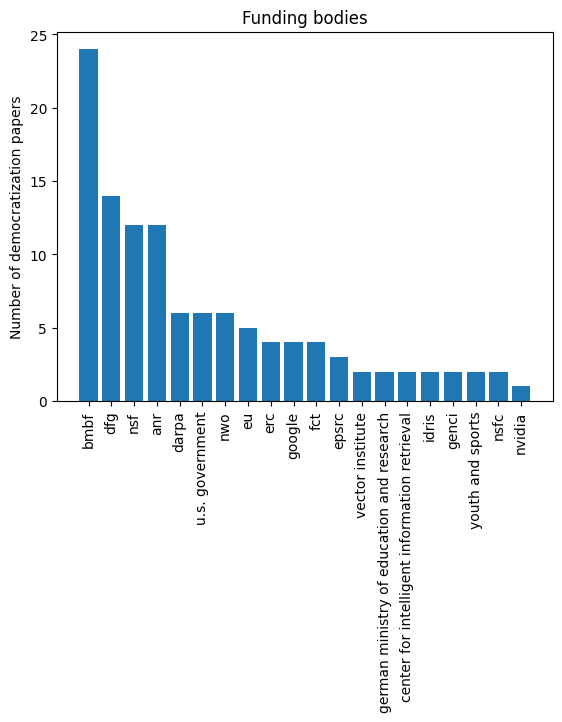

In [50]:
count_orgs = count_acks(all_acks, parses, ent_type="ORG")
print(count_orgs.most_common(20))

acks_plot_data = list(zip(*count_orgs.most_common(k)))
plt.bar(list(acks_plot_data[0]), list(acks_plot_data[1]))
for tick in plt.gca().get_xticklabels():
    tick.set_rotation(90)
plt.ylabel('Number of democratization papers')
plt.title('Funding bodies')
plt.show()

[('huan ling', 1), ('seung wook kim', 1), ('natalie schluter', 1), ('nadejde', 1), ('li et ala', 1), ('pengfei liu', 1), ('rami aly', 1), ('christos christodoulopoulos', 1), ('james thorne', 1), ('fangyu liu', 1), ('martin körling', 1), ('schmidt', 1), ('cortney napoles', 1), ('leonardo neves', 1), ('viktor zamaruiev', 1), ('max gubin', 1), ('lucille njoo', 1), ('vidhisha balachandran', 1), ('melanie sclar', 1), ('tsvetshop', 1)]


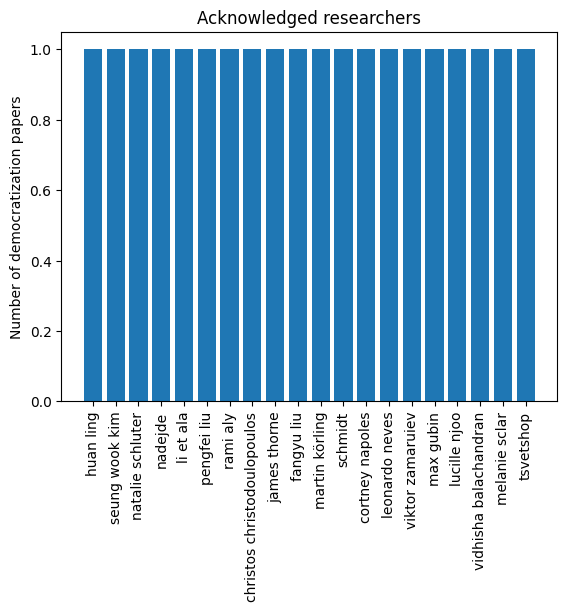

In [55]:
count_persons = count_acks(all_acks, parses, ent_type="PERSON")
print(count_persons.most_common(20))

acks_plot_data = list(zip(*count_persons.most_common(k)))
plt.bar(list(acks_plot_data[0]), list(acks_plot_data[1]))
for tick in plt.gca().get_xticklabels():
    tick.set_rotation(90)
plt.ylabel('Number of democratization papers')
plt.title('Acknowledged researchers')
plt.show()